In [1]:
from model import ModelWrapper, Trainer, ImageDataset

In [ ]:
wrap = ModelWrapper() # model_name 

In [3]:
import os
from typing import List

def collect_image_paths(root_dir: str) -> List[str]:
    """
    Собирает все пути изображений в указанной папке и её подкаталогах.

    Параметры:
        root_dir (str): Корневая папка, в которой будут искаться изображения.

    Возвращает:
        List[str]: Список путей к изображениям.
    """
    image_paths = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [4]:
paths = collect_image_paths(root_dir=f'C:\\Jup\\Хаки-хуяки\\image-similarity\\clip\\train_data_rkn\\dataset')

In [5]:
import random
from typing import Tuple
def split_dataset(image_paths: List[str], val_ratio: float = 0.2) -> Tuple[List[str], List[str]]:
    """
    Перемешивает и разделяет пути изображений на тренировочную и валидационную выборки.

    Параметры:
        image_paths (List[str]): Список путей к изображениям.
        val_ratio (float): Доля данных, которая будет отведена под валидацию.

    Возвращает:
        Tuple[List[str], List[str]]: Тренировочная и валидационная выборки.
    """
    # Перемешиваем данные
    random.shuffle(image_paths)
    
    # Разделяем на тренировочную и валидационную выборки
    val_size = int(len(image_paths) * val_ratio)
    val_paths = image_paths[:val_size]
    train_paths = image_paths[val_size:]
    
    return train_paths, val_paths

In [20]:
train_paths, val_paths = split_dataset(paths)

In [21]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Пример изменения размера, если требуется
    transforms.ToTensor()
])

In [22]:
# Закомментить для всего датасета
train_paths = train_paths[:1024]
val_paths = val_paths[:256]

train_data = ImageDataset(image_paths=train_paths, transform = transform)
val_data = ImageDataset(image_paths=val_paths, transform = transform)

In [23]:
from torch.utils.data import DataLoader
batch_size = 16
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [24]:
visual_parameters = [p for p in wrap.model.vision_model.parameters() if p.requires_grad]
transformer_parameters = [p for p in wrap.model.text_model.parameters() if p.requires_grad]

param_groups = [
    {'params': transformer_parameters[:len(transformer_parameters)//2], 'lr': 1e-6},  # First half of the transformer
    {'params': transformer_parameters[len(transformer_parameters)//2:], 'lr': 3e-6},   # Second half of the transformer
    {'params': visual_parameters[:len(visual_parameters)//2], 'lr': 1e-6},  # First half of the vision transformer
    {'params': visual_parameters[len(visual_parameters)//2:], 'lr': 3e-6},   # Second half of the vision transformer
]
learning_rate = 5e-7
from torch.optim import AdamW
optimizer = AdamW(wrap.model.parameters(), lr=learning_rate, betas=(0.9, 0.995), eps=1e-6, weight_decay=1e-2)

In [25]:
trainer = Trainer(
    model_wrapper=wrap,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer
)

In [26]:
trainer.fit(10)

Validating: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]


Epoch 1/10, Train Loss: 2.7734, Val Loss: 2.7726


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.20it/s]


Epoch 2/10, Train Loss: 2.7725, Val Loss: 2.7726


Validating: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 3/10, Train Loss: 2.7713, Val Loss: 2.7719


Validating: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 4/10, Train Loss: 2.7718, Val Loss: 2.7726


Validating: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 5/10, Train Loss: 2.7726, Val Loss: 2.7725


Validating: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 6/10, Train Loss: 2.7698, Val Loss: 2.7725


Validating: 100%|██████████| 16/16 [00:05<00:00,  3.20it/s]


Epoch 7/10, Train Loss: 2.7725, Val Loss: 2.7725


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]


Epoch 8/10, Train Loss: 2.7724, Val Loss: 2.7723


Validating: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 9/10, Train Loss: 2.7719, Val Loss: 2.7724


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]

Epoch 10/10, Train Loss: 2.7724, Val Loss: 2.7722


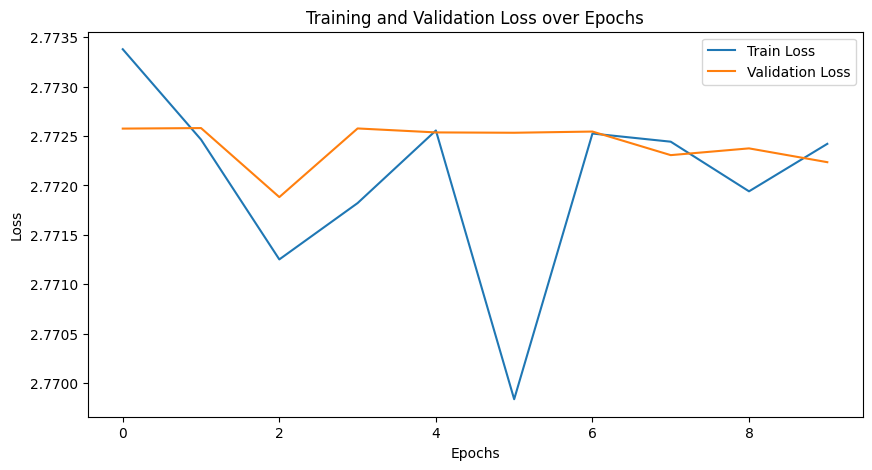

In [27]:
trainer.plot_losses()